# Landfall rainfall

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.datasources import codab, imerg
from src.constants import *
from src import db_utils

## Load data

### Landfall dates

In [67]:
load_path = (
    Path(AA_DATA_DIR)
    / "public"
    / "processed"
    / "moz"
    / "landfall_time_location_fixed_adm1_v7.csv"
)
landfall_df = pd.read_csv(load_path)

In [68]:
# keeping only USA_WIND as this is the most complete wind record
cols = [
    "SID",
    "SEASON",
    "NAME",
    "USA_WIND",
    "LAT",
    "LON",
    "year",
    "month",
    "day",
]

landfall_df = landfall_df[cols]

date_cols = ["year", "month", "day"]
landfall_df[date_cols] = landfall_df[date_cols].astype(int)
landfall_df["landfall_date"] = pd.to_datetime(
    landfall_df[["year", "month", "day"]]
)

# correct single negative USA_WIND
landfall_df["USA_WIND"] = landfall_df["USA_WIND"].abs()

In [69]:
chido_landfall_df = pd.DataFrame(
    {
        "NAME": ["CHIDO"],
        "LON": [40.58],
        "LAT": [-13.37],
        "USA_WIND": 107,
        "landfall_date": [pd.to_datetime("2024-12-15")],
        "SID": "CHIDO",
        "SEASON": 2024,
        "year": 2024,
    }
)
landfall_df = pd.concat([landfall_df, chido_landfall_df], ignore_index=True)

In [70]:
landfall_df

,SID,SEASON,NAME,USA_WIND,LAT,LON,year,month,day,landfall_date
0,1999357S08076,2000,ASTRIDE,25.000000,-13.633333,40.466667,2000,1.0,3.0,2000-01-03
1,2000032S11116,2000,ELINE:LEONE,109.000000,-20.550000,34.750000,2000,2.0,22.0,2000-02-22
2,2000058S14063,2000,GLORIA,25.000000,-23.983333,35.433333,2000,3.0,9.0,2000-03-09
3,2000083S17102,2000,HUDAH,80.000000,-17.200000,38.300000,2000,4.0,8.0,2000-04-08
4,2002364S16045,2003,DELFINA,52.500000,-15.983333,40.066667,2002,10.0,26.0,2002-10-26
5,2003056S21042,2003,JAPHET,86.500000,-21.800000,35.250000,2003,3.0,2.0,2003-03-02
6,2007043S11071,2007,FAVIO,93.333333,-21.900000,35.300000,2007,2.0,22.0,2007-02-22
7,2008062S10064,2008,JOKWE,94.166667,-15.983333,40.133333,2008,3.0,8.0,2008-03-08
8,2009082S16039,2009,IZILDA,15.000000,-20.200000,34.700000,2009,3.0,29.0,2009-03-29
9,2012010S24049,2012,DANDO,NaN,-24.800000,34.500000,2012,1.0,16.0,2012-01-16


### CODAB

In [45]:
adm1 = codab.load_codab(aoi_only=True)

<Axes: >

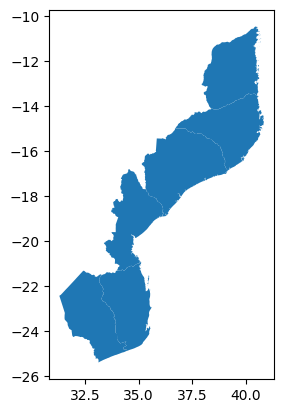

In [46]:
adm1.plot()

In [47]:
aoi_adm1_pcodes = adm1["ADM1_PCODE"].unique()

### IMERG

In [48]:
IMERG_START_DATE = pd.to_datetime("2000-06-01")
extra_days = 1
dfs = []
for sid, row in landfall_df.set_index("SID").iterrows():
    landfall_date = row["landfall_date"]
    start_date = landfall_date - pd.Timedelta(days=extra_days)
    end_date = landfall_date + pd.Timedelta(days=extra_days)
    if end_date < IMERG_START_DATE:
        print(f"{row['NAME']} too early")
        continue
    df_in = imerg.fetch_imerg_data(aoi_adm1_pcodes, start_date, end_date)
    df_in["SID"] = sid
    dfs.append(df_in)

ASTRIDE too early
ELINE:LEONE too early
GLORIA too early
HUDAH too early


In [49]:
imerg_df = pd.concat(dfs, ignore_index=True)

In [50]:
imerg_df

,iso3,pcode,valid_date,adm_level,mean,median,min,max,count,sum,std,SID
0,MOZ,MZ01,2002-10-25,1,0.006358,0.000,0.0,2.175000,2567,16.320000,0.088569,2002364S16045
1,MOZ,MZ01,2002-10-26,1,0.004842,0.000,0.0,0.470000,2567,12.429999,0.034060,2002364S16045
2,MOZ,MZ01,2002-10-27,1,0.004815,0.000,0.0,1.235000,2567,12.360000,0.054999,2002364S16045
3,MOZ,MZ02,2002-10-25,1,0.006411,0.000,0.0,0.465000,2636,16.900000,0.030037,2002364S16045
4,MOZ,MZ02,2002-10-26,1,0.003545,0.000,0.0,0.260000,2636,9.345000,0.019942,2002364S16045
...,...,...,...,...,...,...,...,...,...,...,...,...
427,MOZ,MZ09,2024-12-15,1,0.161504,0.000,0.0,4.855000,2317,374.205000,0.475363,CHIDO
428,MOZ,MZ09,2024-12-16,1,3.942881,0.805,0.0,30.509998,2317,9135.655000,5.216759,CHIDO
429,MOZ,MZ11,2024-12-14,1,0.148604,0.000,0.0,32.225000,3460,514.170000,1.476415,CHIDO
430,MOZ,MZ11,2024-12-15,1,12.196809,7.420,0.0,68.739990,3460,42200.957000,13.829772,CHIDO


In [51]:
imerg_sum_df = imerg_df.groupby(["pcode", "SID"])["mean"].sum().reset_index()
imerg_sum_df = imerg_sum_df.rename(columns={"mean": "sum_mean_rain"})
imerg_sum_df

,pcode,SID,sum_mean_rain
0,MZ01,2002364S16045,0.016015
1,MZ01,2003056S21042,0.171965
2,MZ01,2007043S11071,12.483385
3,MZ01,2008062S10064,47.419393
4,MZ01,2009082S16039,16.721129
...,...,...,...
133,MZ11,2022065S16055,113.405056
134,MZ11,2022110S12051,17.506361
135,MZ11,2023061S22036,191.066692
136,MZ11,2024071S20039,13.794475


## Combine data

In [71]:
combined_df = landfall_df.merge(imerg_sum_df).merge(
    adm1.rename(columns={"ADM1_PCODE": "pcode"})[["pcode", "ADM1_PT"]]
)
combined_df["nameseason"] = (
    combined_df["NAME"].str.capitalize()
    + " "
    + combined_df["year"].astype(str)
)
combined_df

,SID,SEASON,NAME,USA_WIND,LAT,LON,year,month,day,landfall_date,pcode,sum_mean_rain,ADM1_PT,nameseason
0,2002364S16045,2003,DELFINA,52.5,-15.983333,40.066667,2002,10.0,26.0,2002-10-26,MZ01,0.016015,Cabo Delgado,Delfina 2002
1,2002364S16045,2003,DELFINA,52.5,-15.983333,40.066667,2002,10.0,26.0,2002-10-26,MZ02,0.020901,Gaza,Delfina 2002
2,2002364S16045,2003,DELFINA,52.5,-15.983333,40.066667,2002,10.0,26.0,2002-10-26,MZ03,0.072704,Inhambane,Delfina 2002
3,2002364S16045,2003,DELFINA,52.5,-15.983333,40.066667,2002,10.0,26.0,2002-10-26,MZ07,5.913417,Nampula,Delfina 2002
4,2002364S16045,2003,DELFINA,52.5,-15.983333,40.066667,2002,10.0,26.0,2002-10-26,MZ09,6.525196,Sofala,Delfina 2002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,CHIDO,2024,CHIDO,107.0,-13.370000,40.580000,2024,NaN,NaN,2024-12-15,MZ02,1.808856,Gaza,Chido 2024
140,CHIDO,2024,CHIDO,107.0,-13.370000,40.580000,2024,NaN,NaN,2024-12-15,MZ03,2.253145,Inhambane,Chido 2024
141,CHIDO,2024,CHIDO,107.0,-13.370000,40.580000,2024,NaN,NaN,2024-12-15,MZ07,61.004728,Nampula,Chido 2024
142,CHIDO,2024,CHIDO,107.0,-13.370000,40.580000,2024,NaN,NaN,2024-12-15,MZ09,6.135138,Sofala,Chido 2024


## Plot

In [72]:
def calculate_rp(group, col_name, total_seasons):
    group["rank"] = group[col_name].rank(ascending=False)
    group["rp"] = (total_seasons + 1) / group["rank"]
    return group

In [73]:
# seasons for RP calc is total seasons minus current season
total_seasons = combined_df["SEASON"].nunique() - 1

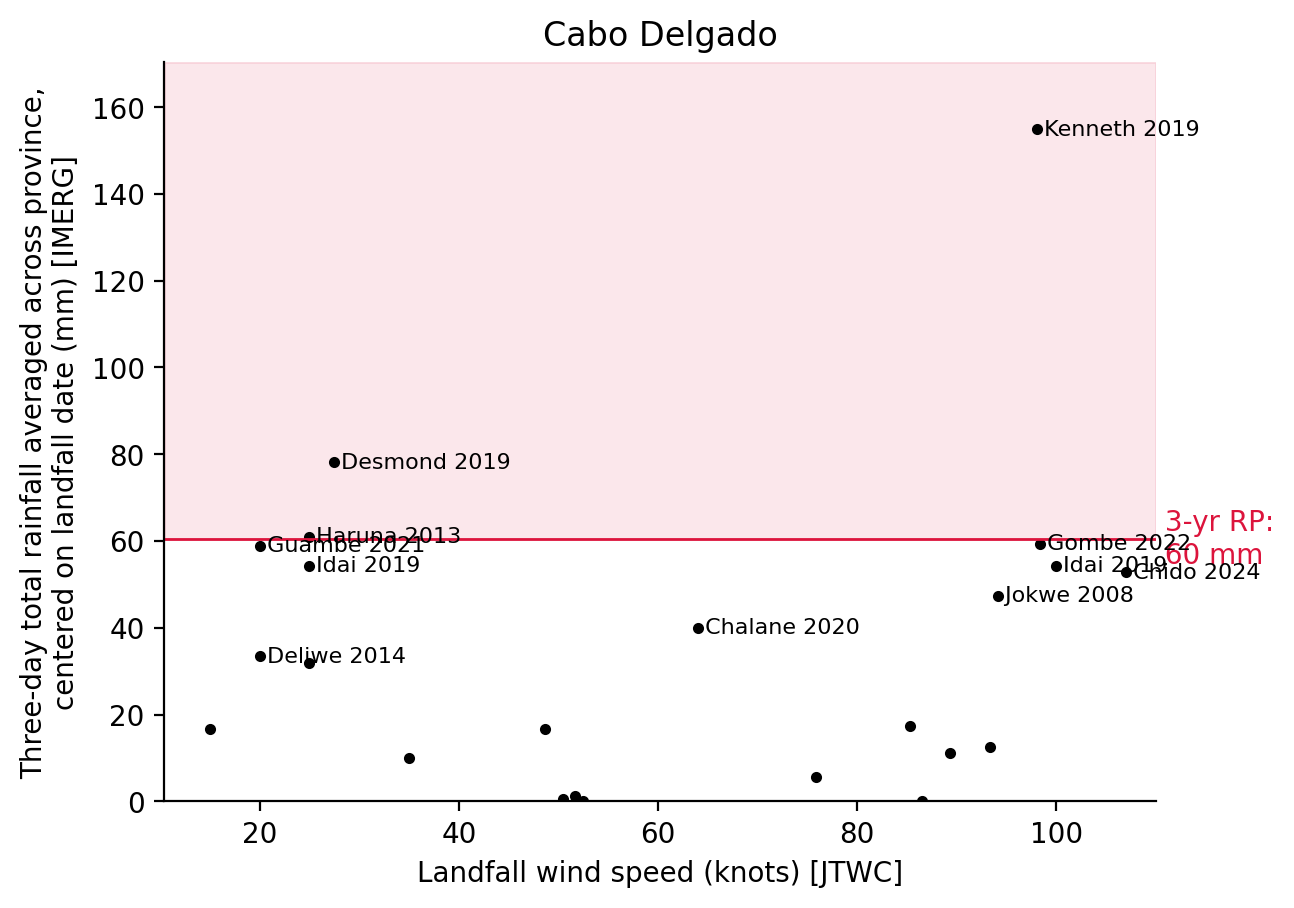

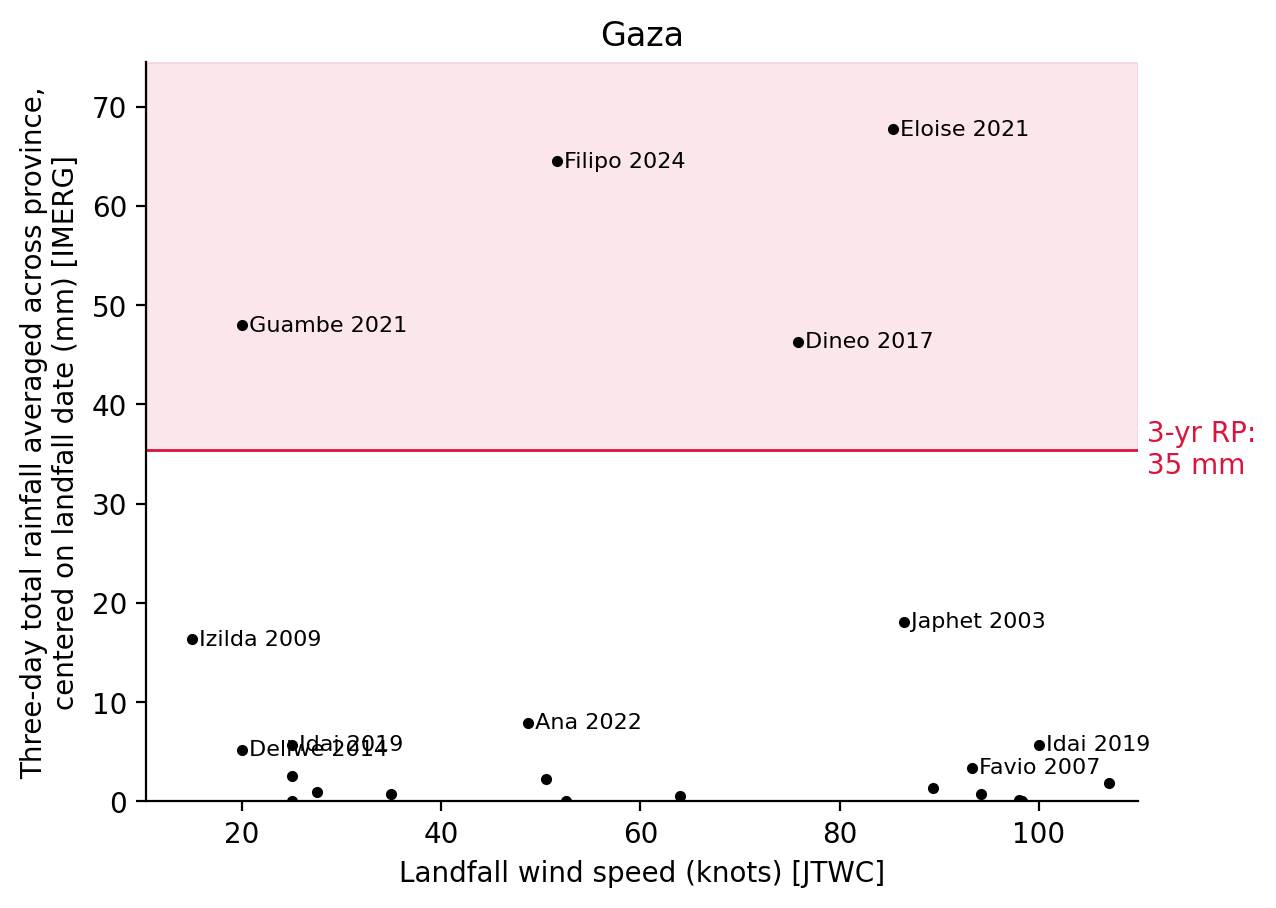

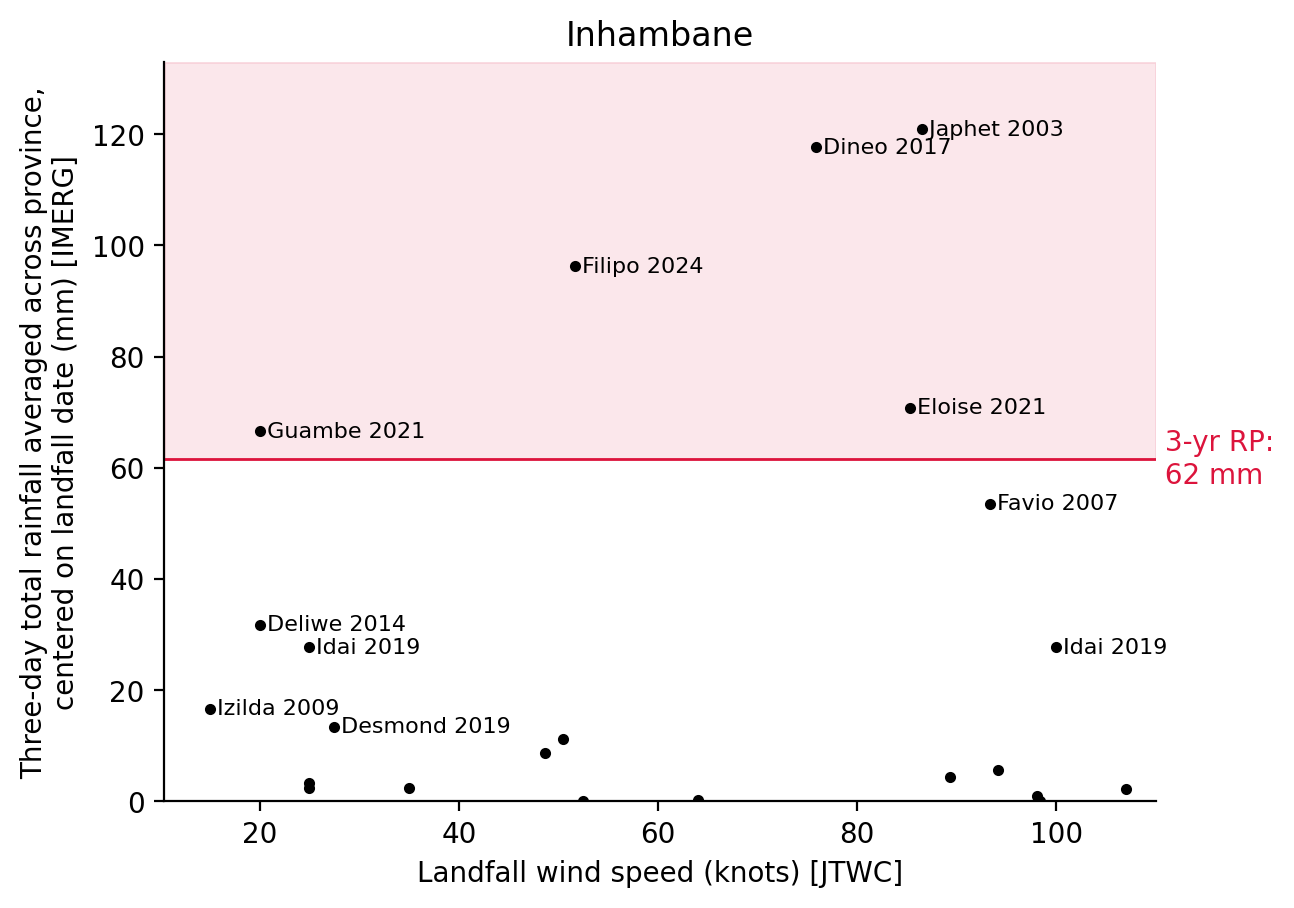

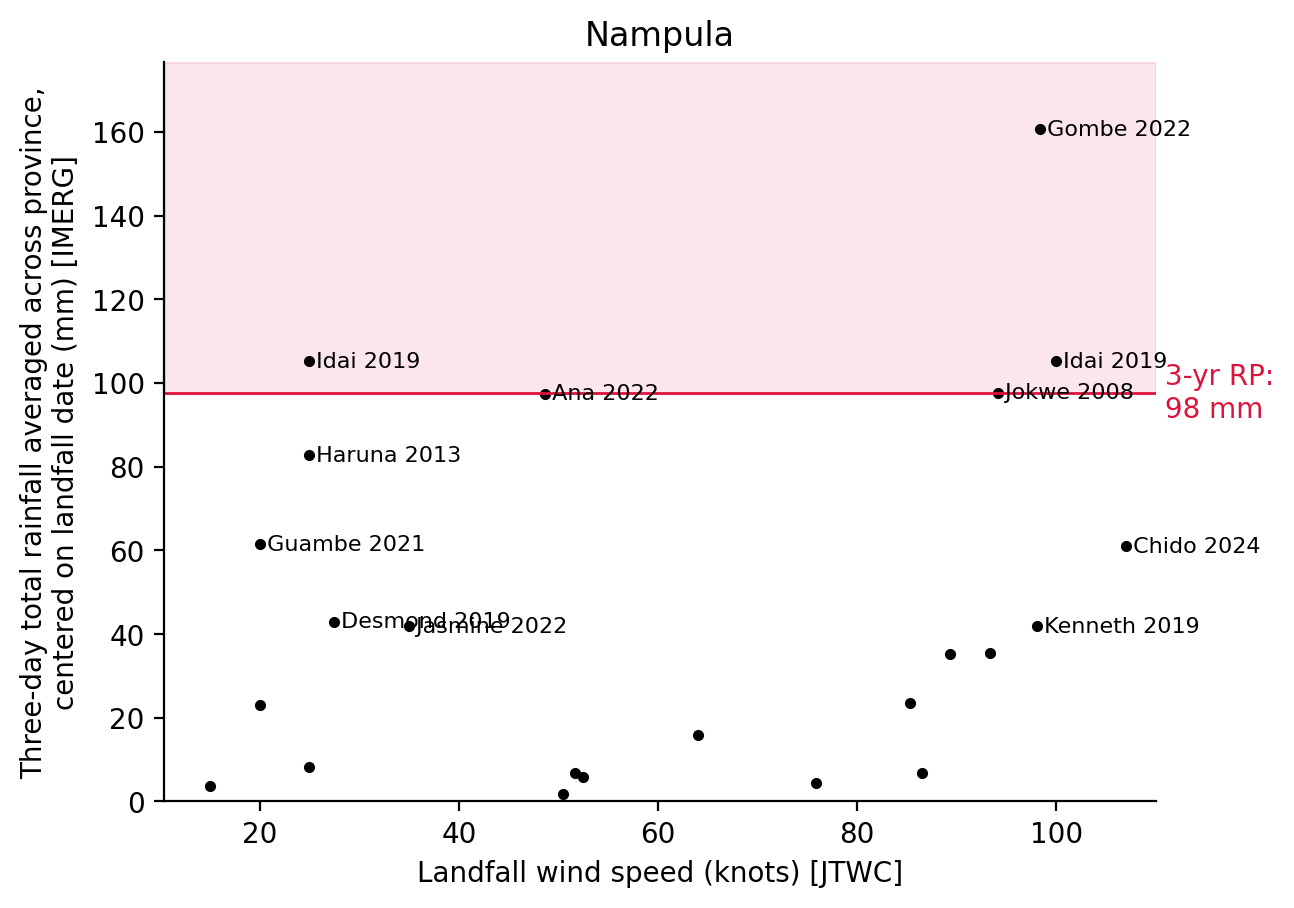

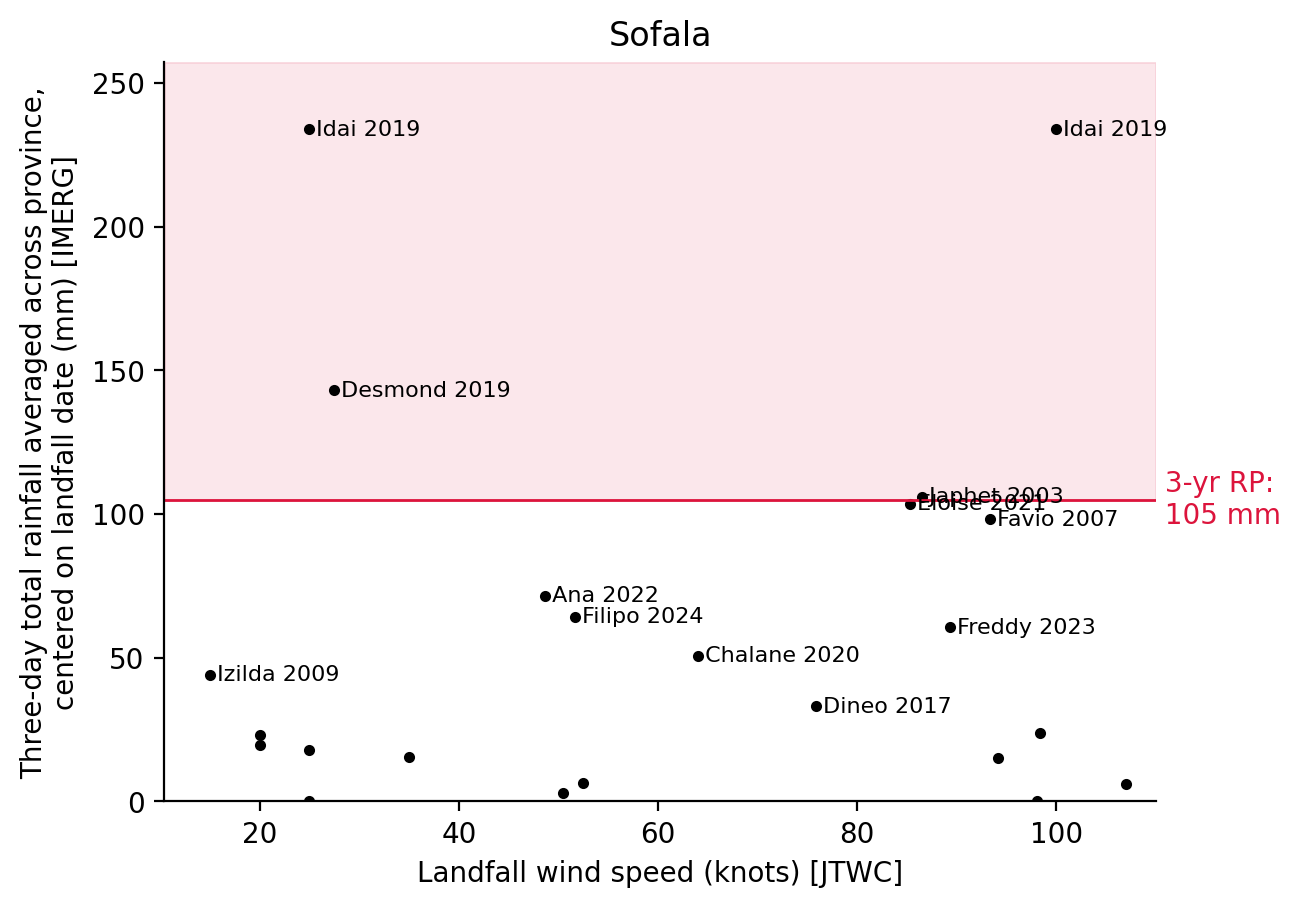

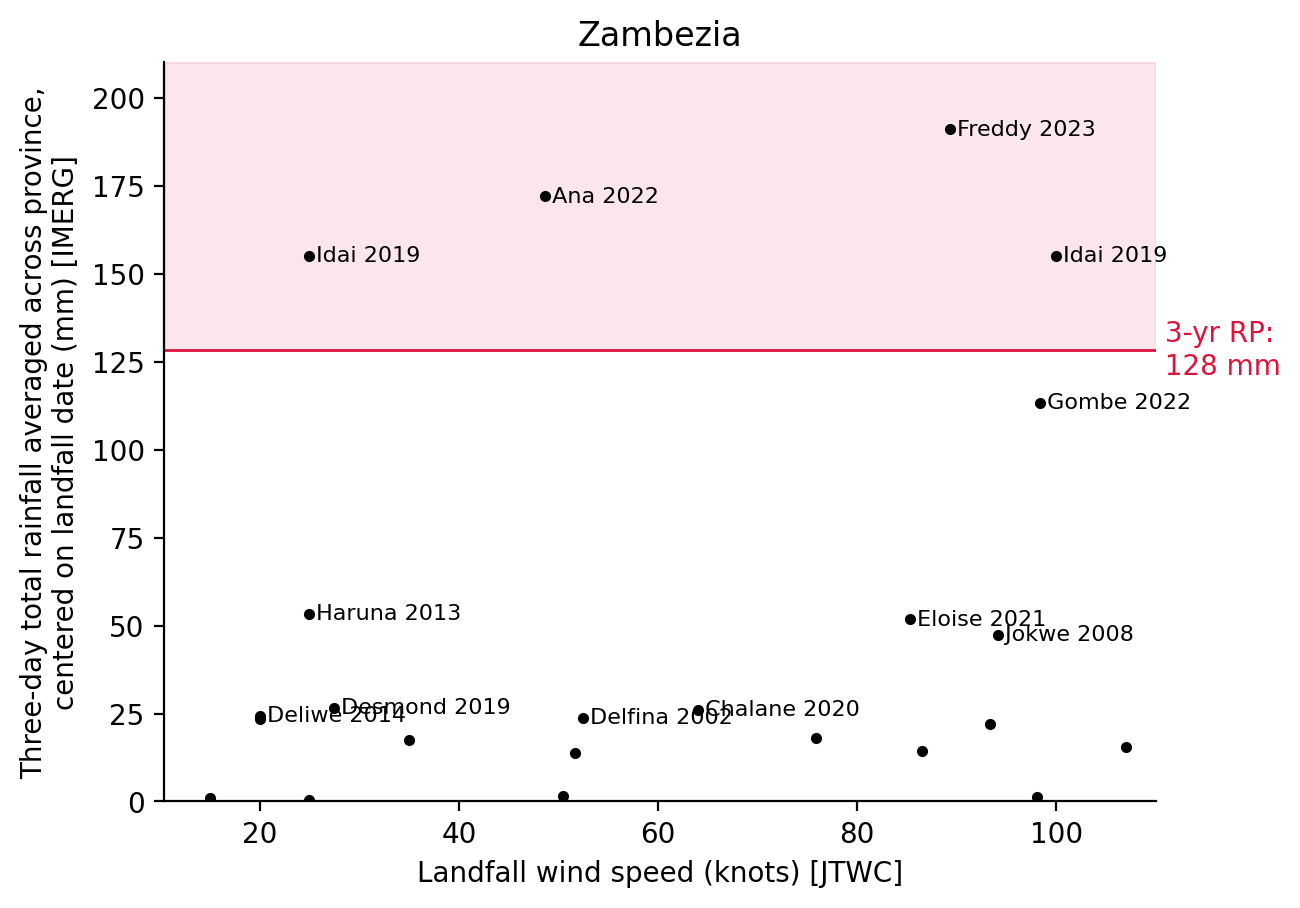

In [74]:
rp = 3
col_name = "sum_mean_rain"
color = "crimson"

for pcode, group in combined_df.groupby("pcode"):
    fig, ax = plt.subplots(dpi=200)

    # calculate RP based only on complete seasons
    dff = group[group["SEASON"] < 2024].copy()
    dff = calculate_rp(dff, col_name, total_seasons)
    dff = dff.sort_values("rp")

    # interpolate return value
    rv = np.interp(rp, dff["rp"], dff[col_name])
    top_edge = dff[col_name].max() * 1.1
    right_edge = dff["USA_WIND"].max() + 10

    group.plot(
        x="USA_WIND",
        y=col_name,
        ax=ax,
        linewidth=0,
        marker=".",
        color="k",
    )
    ax.axhline(rv, linewidth=1, color=color)
    ax.axhspan(rv, top_edge, color=color, alpha=0.1)
    ax.annotate(
        f" 3-yr RP:\n {rv:.0f} mm",
        (right_edge, rv),
        va="center",
        color=color,
    )

    # annotate high rainfall events
    for nameseason, row in group.set_index("nameseason").iterrows():
        if row[col_name] > group[col_name].median():
            ax.annotate(
                f" {nameseason}",
                (row["USA_WIND"], row[col_name]),
                fontsize=8,
                va="center",
            )

    ax.legend().remove()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xlim(right=right_edge)
    ax.set_ylim(bottom=0, top=top_edge)
    ax.set_title(group.iloc[0]["ADM1_PT"])
    ax.set_xlabel("Landfall wind speed (knots) [JTWC]")
    ax.set_ylabel(
        "Three-day total rainfall averaged across province,\ncentered on landfall date (mm) [IMERG]"
    )